In [320]:
import os
import json
from collections import defaultdict, OrderedDict
from os import path
import numpy as np
import matplotlib.pyplot as plt

plt.rc('text', usetex=True)
# plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'w'
plt.rcParams['axes.labelcolor'] = 'k'
plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams['font.serif'] = 'Times'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 18

In [321]:
def load_jsonl(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f.readlines():
            data.append(json.loads(line.strip()))
    
    return data

In [322]:
def get_cluster_spans(coref_chains):
    cluster_spans = []
    for chain in coref_chains:
        min_start = 1e9
        max_end = 0
        for (span_start, span_end) in chain:
            min_start = min(span_start, min_start)
            max_end = max(span_end, max_end)
            
        cluster_spans.append((min_start, max_end))
    return cluster_spans

In [323]:
def get_max_active_chains(cluster_spans):
    last_mention_idx = max([span_end for _, span_end in cluster_spans])
    num_clusters = len(cluster_spans)
    
    # Boolean variable that marks whether a cluster is active at certain time step or not
    active_chains = np.zeros((num_clusters, last_mention_idx), dtype=np.int32)
    for idx, (span_start, span_end) in enumerate(cluster_spans):
        active_chains[idx, span_start:span_end + 1] = 1
    
    active_chain_sum = np.sum(active_chains, axis=0)
    assert(last_mention_idx == len(active_chain_sum)) # Just to make sure summing over right dimension
    
    return np.max(active_chain_sum), np.argmax(active_chain_sum)

In [324]:
def get_doc_tokens(sentences):
    doc_tokens = []
    for sent in sentences:
        doc_tokens.extend(sent)
    return doc_tokens

In [325]:
def get_stats_for_file(train_file):
    print(train_file)
    data = load_jsonl(train_file)
    max_active_chains = 0
    corr_doc_idx = None
    within_doc_idx = None

    active_chains = []
    max_entities = 0
    for doc_idx, instance in enumerate(data):
        cluster_spans = get_cluster_spans(instance["clusters"])
        max_entities = max(max_entities, len(instance["clusters"]))
        if len(cluster_spans):
            instance_max_active_chains, instance_within_doc_idx = get_max_active_chains(cluster_spans)
            if max_active_chains < instance_max_active_chains:
                max_active_chains = instance_max_active_chains
                corr_doc_idx = doc_idx
                within_doc_idx = instance_within_doc_idx
            
            active_chains.append((instance["doc_key"], instance_max_active_chains))
            
    print("Max entities: {}".format(max_entities))
    print("Max active chains: {} present in {}".format(max_active_chains, data[corr_doc_idx]["doc_key"]))
    return active_chains

In [326]:
data_file = "/home/shtoshni/Research/litbank_coref/data/litbank/all_litbank.128.jsonlines"
litbank_active_chains = get_stats_for_file(data_file)

/home/shtoshni/Research/litbank_coref/data/litbank/all_litbank.128.jsonlines
Max entities: 199
Max active chains: 18 present in 2891_howards_end_brat_0


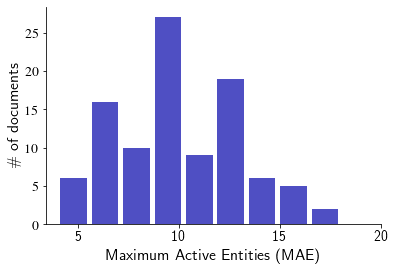

In [327]:
output_dir = "/home/shtoshni/Research/litbank_coref/data/analysis"

_, num_chains = zip(*litbank_active_chains)
# An "interface" to matplotlib.axes.Axes.hist() method

fig, ax = plt.subplots(1)
ax.grid(b=False)
ax.tick_params(axis='y', colors='#000000', direction='out')
ax.tick_params(axis='x', colors='#000000', direction='out')

spines_to_remove = ['top', 'right']
for spine in spines_to_remove:
    ax.spines[spine].set_visible(False)

n, bins, patches = plt.hist(x=num_chains, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)

plt.xticks([5, 10, 15, 20], ['5', '10', '15', '20'])
plt.ylabel('\# of documents')
plt.xlabel('Maximum Active Entities (MAE)')
# plt.title('LitBank')
plt.savefig(path.join(output_dir, "litbank_active_chains.pdf"), dpi=300, bbox_inches='tight')

In [328]:
data_dir = "/home/shtoshni/Research/litbank_coref/data/ontonotes/independent"
train_file = path.join(data_dir, "train.512.jsonlines")
ontonotes_active_chains = get_stats_for_file(train_file)

genres = {"bc": 0, "bn": 0, "mz": 0, "nw": 0, "pt": 0, "tc": 0, "wb": 0}
for doc_key, num_active_chains in active_chains:
    genre = doc_key[:2]
    if genres[genre] < num_active_chains:
        genres[genre] = num_active_chains
        
print(genres)

/home/shtoshni/Research/litbank_coref/data/ontonotes/independent/train.512.jsonlines
Max entities: 94
Max active chains: 24 present in nw/wsj/13/wsj_1366_0
{'bc': 21, 'bn': 19, 'mz': 12, 'nw': 24, 'pt': 16, 'tc': 11, 'wb': 15}


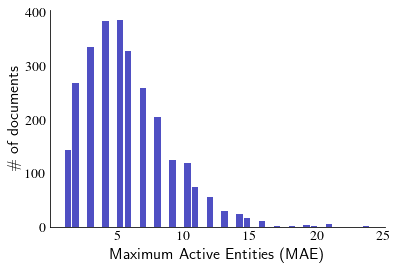

In [329]:
_, num_chains = zip(*active_chains)
# An "interface" to matplotlib.axes.Axes.hist() method

fig, ax = plt.subplots(1)
ax.grid(b=False)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.tick_params(axis='y', colors='#000000')

spines_to_remove = ['top', 'right']
for spine in spines_to_remove:
    ax.spines[spine].set_visible(False)

n, bins, patches = plt.hist(x=num_chains, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)

plt.xticks([5, 10, 15, 20, 25]) #, ['5', '10', '15', '20', '24'])
plt.ylabel('\# of documents')
plt.xlabel('Maximum Active Entities (MAE)')
# plt.title('OntoNotes training set')
plt.savefig(path.join(output_dir, "ontonotes_active_chains.pdf"), dpi=300, bbox_inches='tight')
# plt.

In [330]:
def get_len_stats_for_file(data_file):
    print(data_file)
    data = load_jsonl(data_file)
    corr_doc_idx = None
    within_doc_idx = None

    chain_spread = []
    for doc_idx, instance in enumerate(data):
        no_singleton_clust = []
        for cluster in instance["clusters"]:
            if len(cluster) > 1:
                no_singleton_clust.append(cluster)
#         cluster_spans = get_cluster_spans(instance["clusters"])
        cluster_spans = get_cluster_spans(no_singleton_clust)
        subtoken_map = instance["subtoken_map"]
        doc_len = subtoken_map[-1] + 1 #len(instance["sentence_map"])
#         if len(cluster_spans):
        for (span_start, span_end) in cluster_spans:
            chain_spread.append((subtoken_map[span_end] - subtoken_map[span_start] + 1)/doc_len)
#             chain_spread.append((subtoken_map[span_end] - subtoken_map[span_start] + 1))
#                 chain_spread.append((span_end - span_start))
            
    return chain_spread

/home/shtoshni/Research/litbank_coref/data/litbank/all_litbank.128.jsonlines


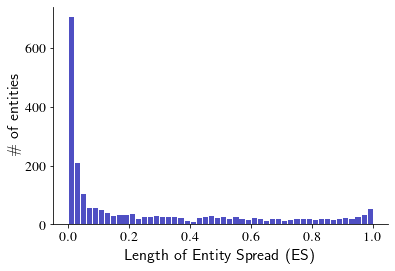

In [331]:
data_file = "/home/shtoshni/Research/litbank_coref/data/litbank/all_litbank.128.jsonlines"
chain_spread = get_len_stats_for_file(data_file)
# print(chain_spread)
# print(len(chain_spread))

fig, ax = plt.subplots(1)
ax.grid(b=False)
ax.tick_params(axis='y', colors='#000000', direction='out')
ax.tick_params(axis='x', colors='#000000', direction='out')

spines_to_remove = ['top', 'right']
for spine in spines_to_remove:
    ax.spines[spine].set_visible(False)

n, bins, patches = plt.hist(chain_spread, color='#0504aa', 
                            alpha=0.7, bins=np.arange(0, 1.01, 0.02), rwidth=0.85)
# n, bins, patches = plt.hist(chain_spread, color='#0504aa', bins=np.arange(0, 3000, 50),
#                             alpha=0.7, rwidth=0.85)

plt.ylabel('\# of entities')
plt.xlabel('Length of Entity Spread (ES)')
# plt.title('LitBank')
plt.savefig(path.join(output_dir, "litbank_entity_spread.pdf"), dpi=300, bbox_inches='tight')

/home/shtoshni/Research/litbank_coref/data/ontonotes/independent/train.512.jsonlines


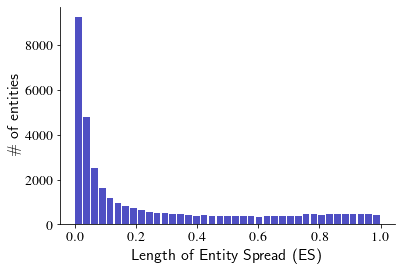

In [332]:
data_dir = "/home/shtoshni/Research/litbank_coref/data/ontonotes/independent"
train_file = path.join(data_dir, "train.512.jsonlines")

chain_spread = get_len_stats_for_file(train_file)
# print(chain_spread)
# print(len(chain_spread))

fig, ax = plt.subplots(1)
ax.grid(b=False)
ax.tick_params(axis='y', colors='#000000', direction='out')
ax.tick_params(axis='x', colors='#000000', direction='out')

spines_to_remove = ['top', 'right']
for spine in spines_to_remove:
    ax.spines[spine].set_visible(False)

n, bins, patches = plt.hist(x=chain_spread, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)

plt.ylabel('\# of entities')
plt.xlabel('Length of Entity Spread (ES)')
# plt.title('OntoNotes Training Set')
plt.savefig(path.join(output_dir, "ontonotes_entity_spread.pdf"), dpi=300, bbox_inches='tight')